# 第04章: 04 Linear Models Simulation

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


## 📖 線形モデル：シンプルだが強力な武器「シンプルなものほど美しい」という言葉があります。機械学習の世界でも、最もシンプルな線形モデルは、多くの実務問題で驚くほど良い結果を出します。### 線形モデルとは？線形モデルは、入力（特徴量）と出力（予測値）の関係を直線（または平面・超平面）で表すモデルです。**1次元の例（y = ax + b）**：```住宅価格 = 面積 × 単価 + 基本価格```**多次元の例**：```住宅価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + ... + b```### なぜ線形モデルを学ぶのか？**1. 解釈しやすい**：- 各特徴量の重要度が数値（重み）で分かる- ビジネスの意思決定に使いやすい- 規制産業（金融、医療など）でも使える**2. 計算が高速**：- 学習が速い（数秒〜数分）- 予測も高速（リアルタイム処理可能）- 大規模データでも扱える**3. 過学習しにくい**：- パラメータ数が少ない- 正則化で制御しやすい- 小規模データでも使える**4. ベースラインとして重要**：- まず線形モデルを試すのが定石- 複雑なモデルと比較する基準になる- 「シンプルなモデルで十分」なことも多い### 実世界での応用例線形モデルは、以下のような場面で実際に使われています：**1. 金融**：- 信用スコアリング（ローン審査）- 株価予測- 詐欺検出**2. マーケティング**：- 売上予測- 価格最適化- 顧客生涯価値の推定**3. 医療**：- 疾患リスク予測- 治療効果の予測- 医療費予測**4. 製造業**：- 需要予測- 品質予測- 故障予測### このノートブックで学ぶこと- **線形回帰**: 連続値の予測（価格、売上など）- **ロジスティック回帰**: 分類問題（Yes/No、カテゴリー）- **正則化**: 過学習を防ぐ技術（Ridge、Lasso）- **特徴量の重要度**: モデルの解釈方法それでは、データを生成しながら線形モデルを学んでいきましょう！

## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    LogisticRegression, RidgeClassifier
)
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

### 🎲 ロジスティック回帰：分類問題への応用名前に「回帰」とありますが、ロジスティック回帰は**分類**アルゴリズムです。#### なぜ線形回帰では分類できないのか？**例：スパムメール判定**線形回帰で試すと：```スコア = 単語頻度1×w1 + 単語頻度2×w2 + ...結果: -5.2, 0.3, 1.8, 25.7, ...問題: これをどうやって「スパム or 正常」に変換する？```出力が連続値（-∞ to +∞）なので、0 or 1 の分類に直接使えません。#### シグモイド関数による変換ロジスティック回帰は、線形回帰の出力を**シグモイド関数**で0〜1の範囲に変換します：```P(y=1) = 1 / (1 + e^(-z))z = wx + b (線形回帰と同じ)```**シグモイド関数の特徴**：```入力(z)    出力P(y=1)-∞    →    0-2    →    0.120     →    0.50+2    →    0.88+∞    →    1.00どんな入力でも、出力は0〜1の範囲に収まるこれを確率として解釈できる！```#### 確率から分類へ```P(スパム) = 0.85 → スパムと判定P(スパム) = 0.23 → 正常メールと判定閾値（デフォルト: 0.5）を超えたら陽性と判定```#### ロジスティック回帰の具体例**顧客の購入予測**：```購入確率 = sigmoid(年齢×w1 + 収入×w2 + 訪問回数×w3 + b)例:年齢30歳、収入500万円、訪問回数10回の顧客z = 30×0.02 + 500×0.001 + 10×0.3 + (-2)  = 0.6 + 0.5 + 3 - 2  = 2.1P(購入) = 1 / (1 + e^(-2.1))        = 1 / (1 + 0.122)        = 0.89 (89%)→ 購入する可能性が高い！```#### 多クラス分類ロジスティック回帰は、2クラスだけでなく多クラスにも対応できます。**ソフトマックス回帰（Softmax Regression）**：```3クラス分類（A, B, C）の例:P(A) = e^(z_A) / (e^(z_A) + e^(z_B) + e^(z_C))P(B) = e^(z_B) / (e^(z_A) + e^(z_B) + e^(z_C))P(C) = e^(z_C) / (e^(z_A) + e^(z_B) + e^(z_C))P(A) + P(B) + P(C) = 1.0 （確率の合計は1）例:P(A) = 0.7P(B) = 0.2P(C) = 0.1→ クラスAと予測```#### 決定境界の可視化ロジスティック回帰の決定境界は直線（または平面）になります：```2次元空間での境界:  特徴量2    ↑    │  ●●●     ○○○    │  ●●●  ／ ○○○    │  ●●● ／  ○○○    │      ／    │  ●●／●    │  ●／●●    └─────────→ 特徴量1境界線の左側: クラス●境界線の右側: クラス○```#### ロジスティック回帰 vs 他の分類器**線形SVM**：- 境界線からの「マージン」を最大化- 外れ値に強い- 確率を直接出力しない**決定木**：- 非線形な境界を作れる- 特徴量間の相互作用を捉える- 解釈しやすい（ルールが見える）**ニューラルネットワーク**：- 複雑な非線形関係を学習- 大量のデータが必要- 計算コストが高い**ロジスティック回帰の強み**：- 計算が速い- 確率を直接出力（意思決定に使いやすい）- 正則化で過学習を防ぎやすい- 大規模データでも使える#### 実務での応用例**1. クレジットカード不正検出**：```P(不正) = sigmoid(金額×w1 + 時刻×w2 + 場所×w3 + ...)P(不正) > 0.9 → 取引を停止P(不正) = 0.5-0.9 → 追加認証を要求P(不正) < 0.5 → 取引を承認```**2. メールの優先度判定**：```P(重要) = sigmoid(送信者×w1 + 件名×w2 + ...)P(重要) > 0.8 → 通知を送るP(重要) < 0.8 → 通知しない```**3. 病気の診断補助**：```P(疾患) = sigmoid(症状1×w1 + 症状2×w2 + ...)P(疾患) > 0.7 → 精密検査を推奨P(疾患) < 0.7 → 経過観察```確率が出力されるので、閾値を調整してリスクとコストのバランスを取れます。

## Part 1: Linear Regression Fundamentals

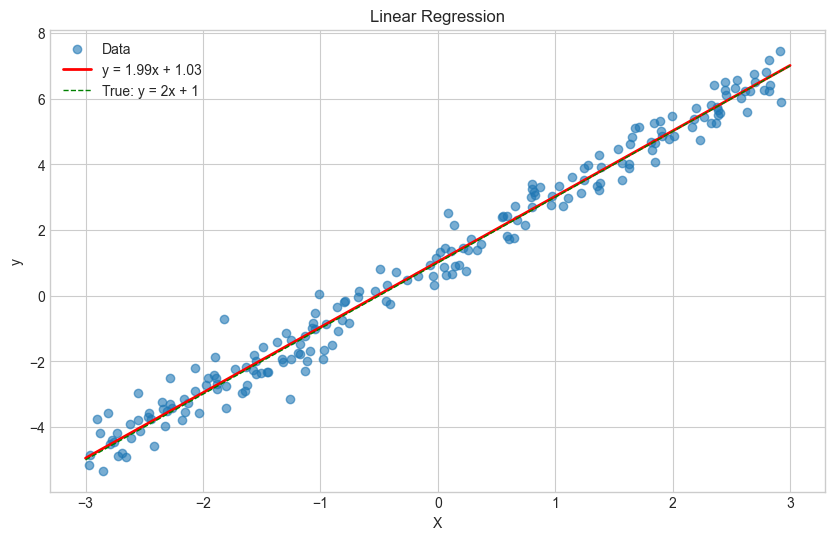

Learned coefficient: 1.9935 (true: 2.0)
Learned intercept: 1.0331 (true: 1.0)
R² score: 0.9815


In [2]:
# Generate simple linear data
n_samples = 200
X = np.random.uniform(-3, 3, n_samples).reshape(-1, 1)
y_true = 2 * X.ravel() + 1  # y = 2x + 1
y = y_true + np.random.randn(n_samples) * 0.5  # Add noise

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predict
X_line = np.linspace(-3, 3, 100).reshape(-1, 1)
y_pred = model.predict(X_line)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, label='Data')
plt.plot(X_line, y_pred, 'r-', linewidth=2, label=f'y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')
plt.plot(X_line, 2 * X_line + 1, 'g--', linewidth=1, label='True: y = 2x + 1')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

print(f"Learned coefficient: {model.coef_[0]:.4f} (true: 2.0)")
print(f"Learned intercept: {model.intercept_:.4f} (true: 1.0)")
print(f"R² score: {model.score(X, y):.4f}")

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 2: Effect of Noise Level

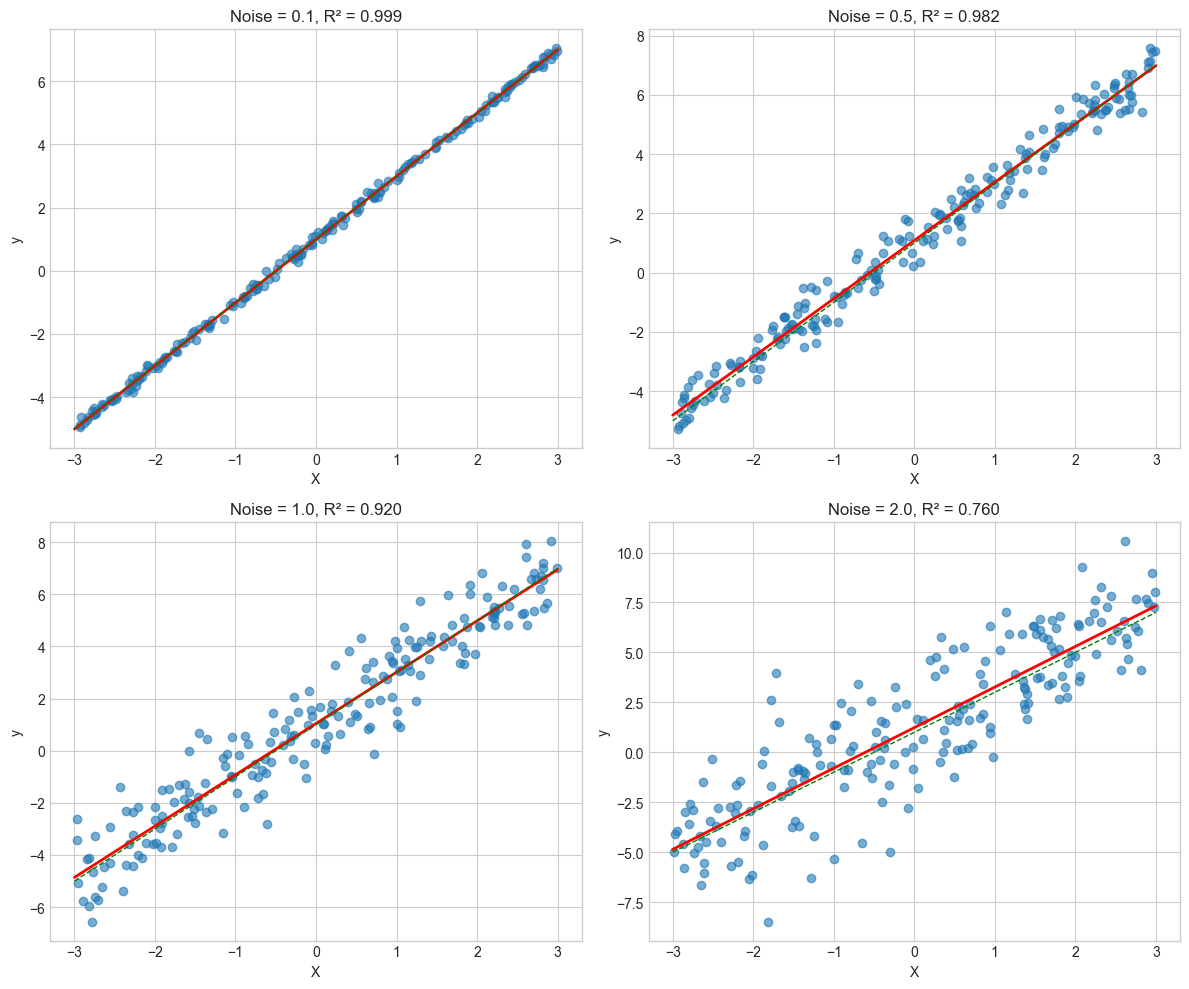


Effect of Noise on Model Performance:
 noise     coef  intercept       r2
   0.1 2.001363   0.994710 0.999214
   0.5 1.966477   1.090019 0.981670
   1.0 1.968258   1.045973 0.920054
   2.0 2.030689   1.234418 0.759823


In [3]:
# Simulate different noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

results = []

for idx, noise in enumerate(noise_levels):
    # Generate data
    X = np.random.uniform(-3, 3, n_samples).reshape(-1, 1)
    y = 2 * X.ravel() + 1 + np.random.randn(n_samples) * noise
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X_line)
    r2 = model.score(X, y)
    
    results.append({
        'noise': noise,
        'coef': model.coef_[0],
        'intercept': model.intercept_,
        'r2': r2
    })
    
    # Plot
    axes[idx].scatter(X, y, alpha=0.6)
    axes[idx].plot(X_line, y_pred, 'r-', linewidth=2)
    axes[idx].plot(X_line, 2 * X_line + 1, 'g--', linewidth=1)
    axes[idx].set_title(f'Noise = {noise}, R² = {r2:.3f}')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')

plt.tight_layout()
plt.show()

# Summary table
df_results = pd.DataFrame(results)
print("\nEffect of Noise on Model Performance:")
print(df_results.to_string(index=False))

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 3: Regularization - Ridge, Lasso, ElasticNet

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate high-dimensional data with some irrelevant features
X, y, coef_true = make_regression(
    n_samples=200, n_features=50, n_informative=10,
    noise=10, coef=True, random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"True non-zero coefficients: {np.sum(coef_true != 0)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")

True non-zero coefficients: 10
Training samples: 160
Features: 50


**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [5]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare regularization methods
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)
}

results = []
coefs = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    n_nonzero = np.sum(np.abs(model.coef_) > 0.01)
    
    results.append({
        'Model': name,
        'Train R²': train_score,
        'Test R²': test_score,
        'Non-zero coefs': n_nonzero
    })
    coefs[name] = model.coef_

df_results = pd.DataFrame(results)
print("Model Comparison:")
print(df_results.to_string(index=False))

Model Comparison:
     Model  Train R²  Test R²  Non-zero coefs
    Linear  0.996363 0.986601              49
     Ridge  0.996307 0.986690              50
     Lasso  0.994835 0.990546              21
ElasticNet  0.888593 0.808952              47


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

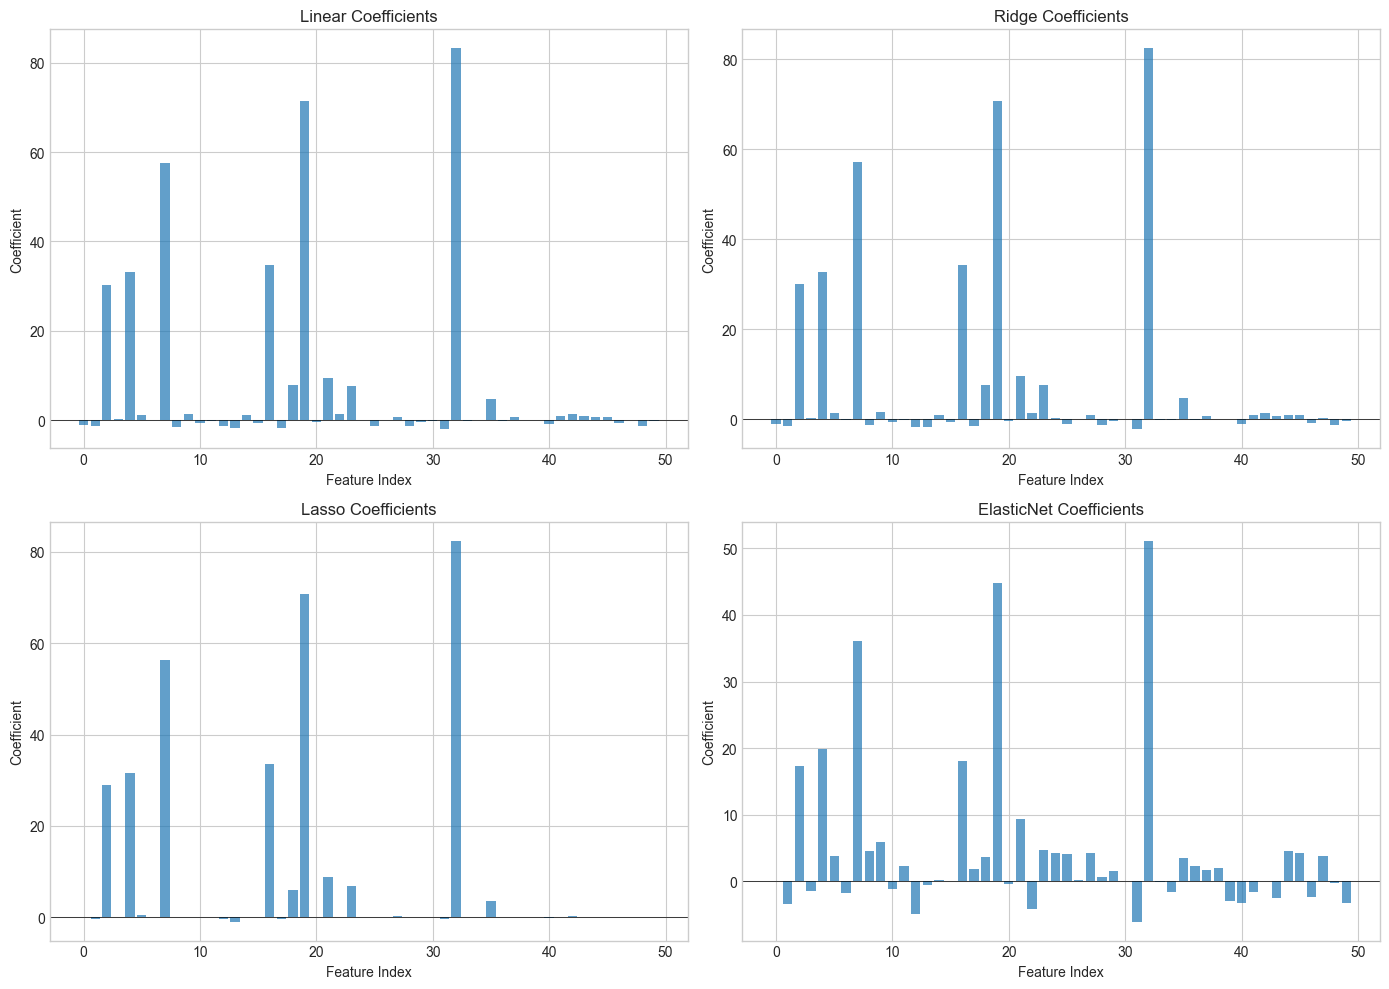

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Visualize coefficient magnitudes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, coef) in enumerate(coefs.items()):
    axes[idx].bar(range(len(coef)), coef, alpha=0.7)
    axes[idx].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[idx].set_xlabel('Feature Index')
    axes[idx].set_ylabel('Coefficient')
    axes[idx].set_title(f'{name} Coefficients')

plt.tight_layout()
plt.show()

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

## Part 4: Alpha Parameter Sweep

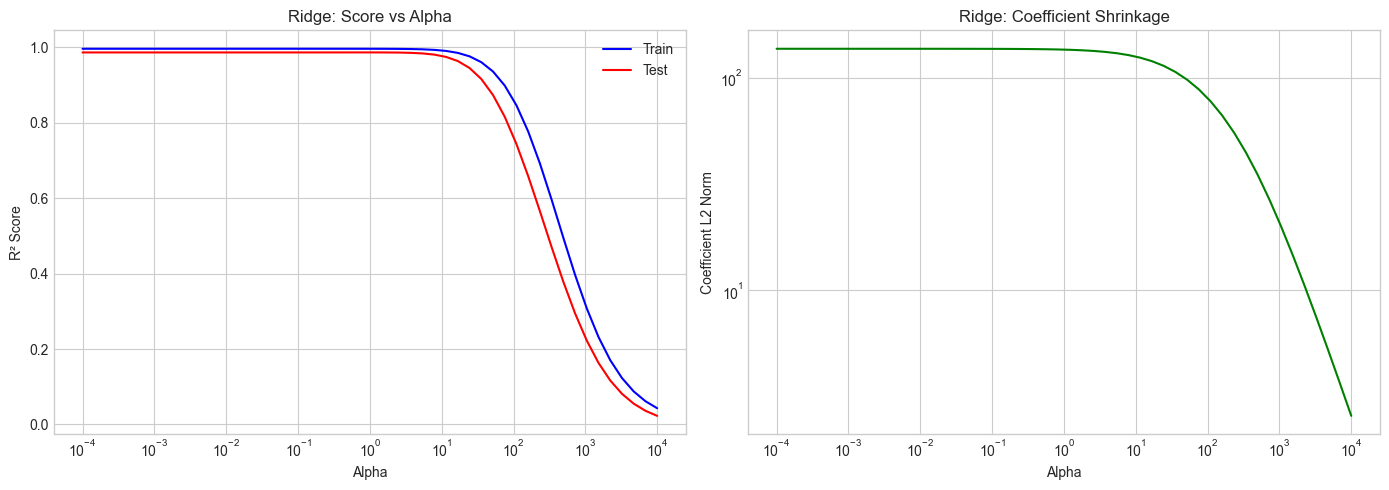

Optimal alpha: 0.8286
Best test R²: 0.9867


In [7]:
# Sweep alpha values for Ridge
alphas = np.logspace(-4, 4, 50)

ridge_train_scores = []
ridge_test_scores = []
ridge_coef_norms = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    
    ridge_train_scores.append(model.score(X_train_scaled, y_train))
    ridge_test_scores.append(model.score(X_test_scaled, y_test))
    ridge_coef_norms.append(np.linalg.norm(model.coef_))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scores vs alpha
axes[0].semilogx(alphas, ridge_train_scores, 'b-', label='Train')
axes[0].semilogx(alphas, ridge_test_scores, 'r-', label='Test')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Ridge: Score vs Alpha')
axes[0].legend()
axes[0].grid(True)

# Coefficient norm vs alpha
axes[1].loglog(alphas, ridge_coef_norms, 'g-')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient L2 Norm')
axes[1].set_title('Ridge: Coefficient Shrinkage')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal alpha
optimal_idx = np.argmax(ridge_test_scores)
print(f"Optimal alpha: {alphas[optimal_idx]:.4f}")
print(f"Best test R²: {ridge_test_scores[optimal_idx]:.4f}")

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

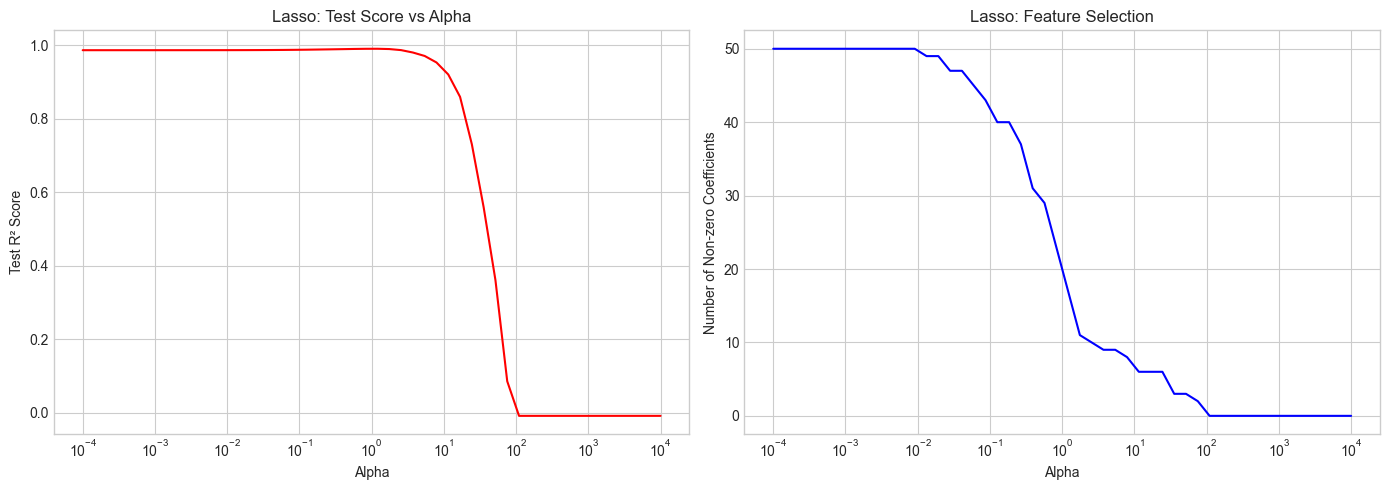

In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Sweep alpha for Lasso - observe sparsity
lasso_n_nonzero = []
lasso_test_scores = []

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    
    lasso_test_scores.append(model.score(X_test_scaled, y_test))
    lasso_n_nonzero.append(np.sum(np.abs(model.coef_) > 1e-6))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(alphas, lasso_test_scores, 'r-')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Test R² Score')
axes[0].set_title('Lasso: Test Score vs Alpha')
axes[0].grid(True)

axes[1].semilogx(alphas, lasso_n_nonzero, 'b-')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Number of Non-zero Coefficients')
axes[1].set_title('Lasso: Feature Selection')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 5: Effect of Multicollinearity

In [9]:
# Generate data with correlated features
n_samples = 200

# Independent features
X1 = np.random.randn(n_samples)
X2 = np.random.randn(n_samples)

# Correlated feature (X3 ≈ X1 + noise)
X3 = X1 + np.random.randn(n_samples) * 0.1  # Highly correlated with X1

# Create target
y = 3 * X1 + 2 * X2 + np.random.randn(n_samples) * 0.5

# Compare models with/without correlated feature
X_no_corr = np.column_stack([X1, X2])
X_with_corr = np.column_stack([X1, X2, X3])

print(f"Correlation between X1 and X3: {np.corrcoef(X1, X3)[0, 1]:.4f}")

Correlation between X1 and X3: 0.9953


In [10]:
# Compare Linear Regression vs Ridge with multicollinearity
from sklearn.model_selection import cross_val_score

models_mc = {
    'Linear (no corr)': (LinearRegression(), X_no_corr),
    'Linear (with corr)': (LinearRegression(), X_with_corr),
    'Ridge (with corr)': (Ridge(alpha=1.0), X_with_corr)
}

print("Effect of Multicollinearity:")
print("="*60)

for name, (model, X_data) in models_mc.items():
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_data)
    
    # Fit
    model.fit(X_scaled, y)
    
    # CV score
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    
    print(f"\n{name}:")
    print(f"  Coefficients: {model.coef_}")
    print(f"  CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Effect of Multicollinearity:

Linear (no corr):
  Coefficients: [2.96491862 1.92310489]
  CV R² Score: 0.9782 (+/- 0.0127)

Linear (with corr):
  Coefficients: [ 3.55827599  1.92881221 -0.59602048]
  CV R² Score: 0.9785 (+/- 0.0123)

Ridge (with corr):
  Coefficients: [2.46828424 1.90866505 0.48627827]
  CV R² Score: 0.9772 (+/- 0.0132)


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 6: Effect of Outliers

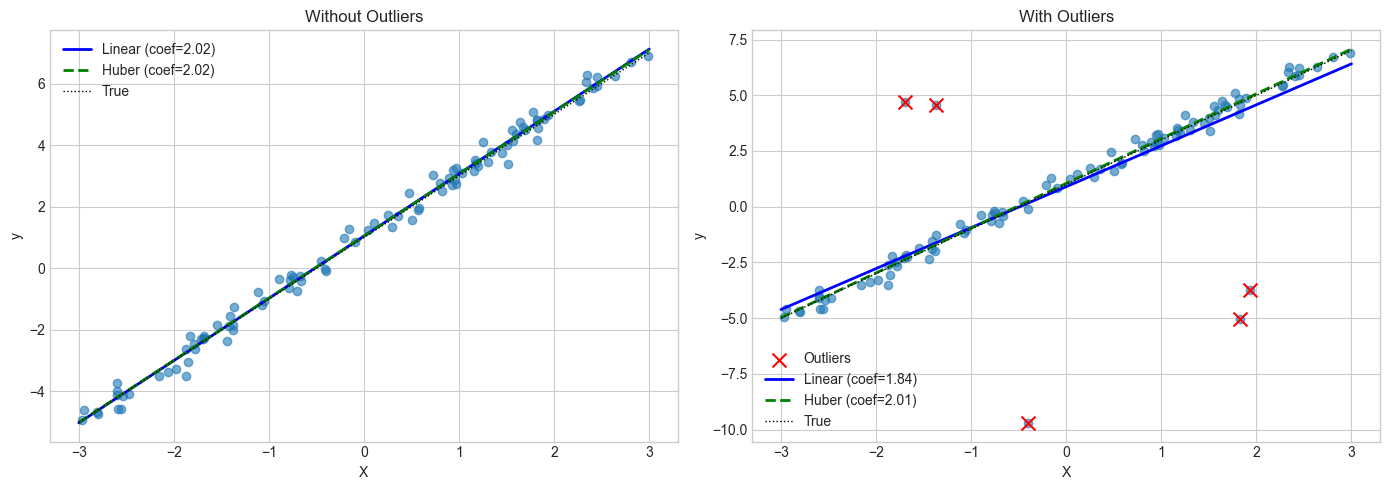

In [11]:
# Generate data with outliers
n_samples = 100
X = np.random.uniform(-3, 3, n_samples).reshape(-1, 1)
y = 2 * X.ravel() + 1 + np.random.randn(n_samples) * 0.3

# Add outliers
n_outliers = 5
outlier_idx = np.random.choice(n_samples, n_outliers, replace=False)
y_outliers = y.copy()
y_outliers[outlier_idx] += np.random.uniform(5, 10, n_outliers) * np.sign(np.random.randn(n_outliers))

# Compare models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

X_line = np.linspace(-3, 3, 100).reshape(-1, 1)

for idx, (y_data, title) in enumerate([(y, 'Without Outliers'), (y_outliers, 'With Outliers')]):
    # Fit models
    lr = LinearRegression().fit(X, y_data)
    
    # Use Huber loss for robust regression
    from sklearn.linear_model import HuberRegressor
    huber = HuberRegressor().fit(X, y_data)
    
    # Plot
    axes[idx].scatter(X, y_data, alpha=0.6)
    if idx == 1:
        axes[idx].scatter(X[outlier_idx], y_data[outlier_idx], c='red', s=100, marker='x', label='Outliers')
    
    axes[idx].plot(X_line, lr.predict(X_line), 'b-', lw=2, label=f'Linear (coef={lr.coef_[0]:.2f})')
    axes[idx].plot(X_line, huber.predict(X_line), 'g--', lw=2, label=f'Huber (coef={huber.coef_[0]:.2f})')
    axes[idx].plot(X_line, 2 * X_line + 1, 'k:', lw=1, label='True')
    
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(title)
    axes[idx].legend()

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 7: Polynomial Regression

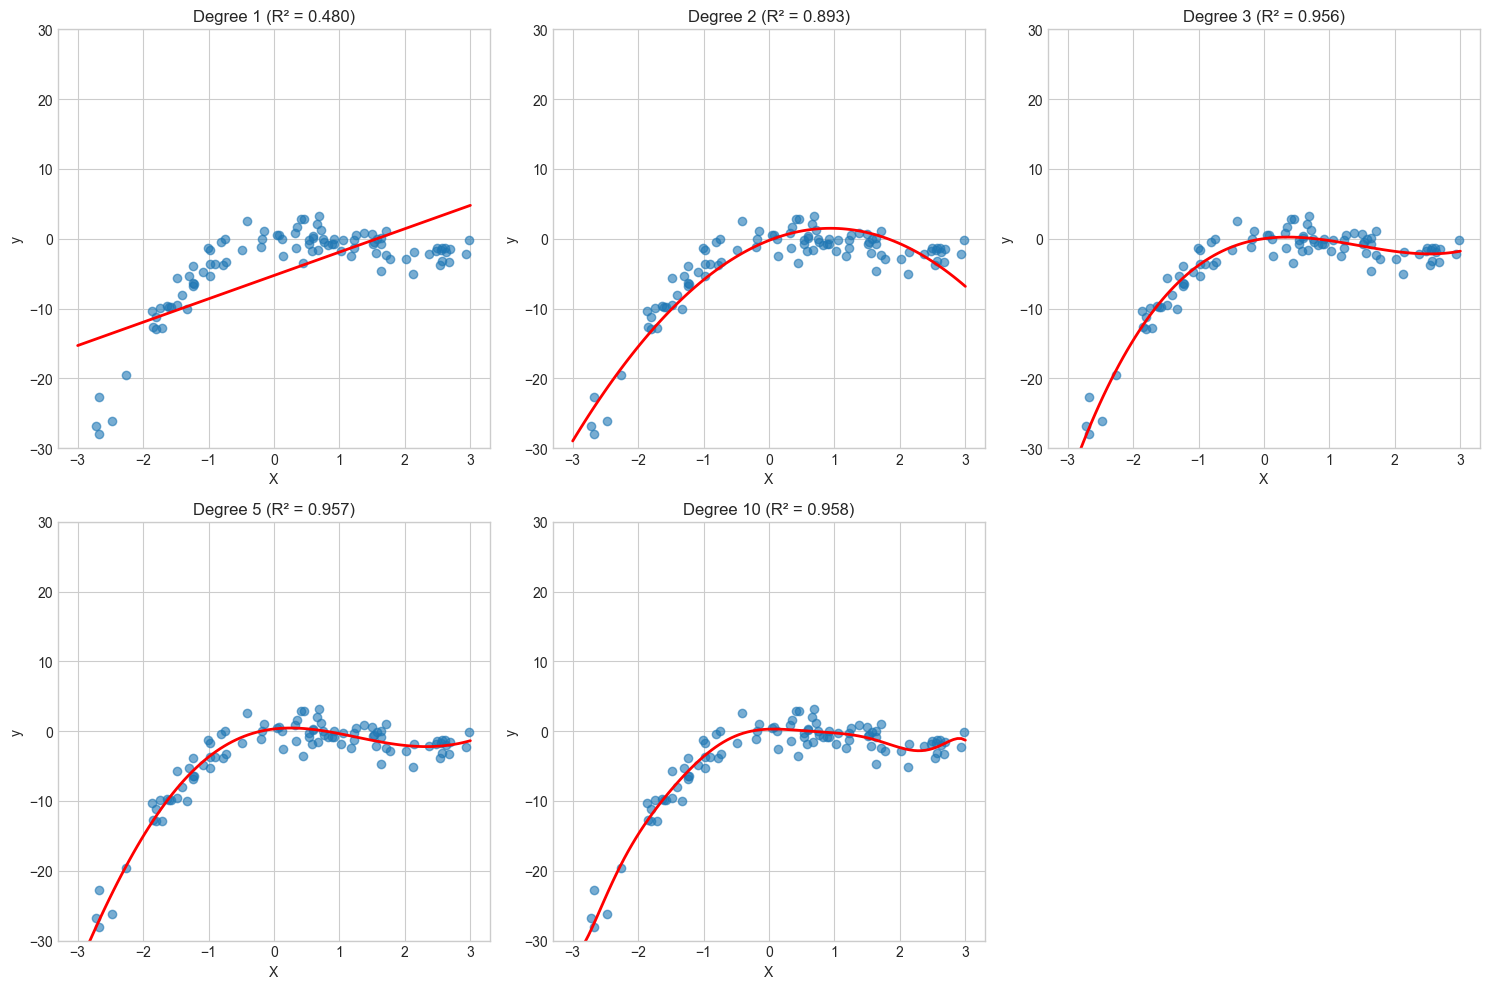

In [12]:
# Generate non-linear data
n_samples = 100
X = np.sort(np.random.uniform(-3, 3, n_samples)).reshape(-1, 1)
y = 0.5 * X.ravel()**3 - 2 * X.ravel()**2 + X.ravel() + np.random.randn(n_samples) * 2

# Compare different polynomial degrees
degrees = [1, 2, 3, 5, 10]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_plot_poly = poly.transform(X_plot)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict
    y_pred = model.predict(X_plot_poly)
    
    # Calculate scores
    train_score = model.score(X_poly, y)
    
    # Plot
    axes[idx].scatter(X, y, alpha=0.6)
    axes[idx].plot(X_plot, y_pred, 'r-', lw=2)
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(f'Degree {degree} (R² = {train_score:.3f})')
    axes[idx].set_ylim(-30, 30)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

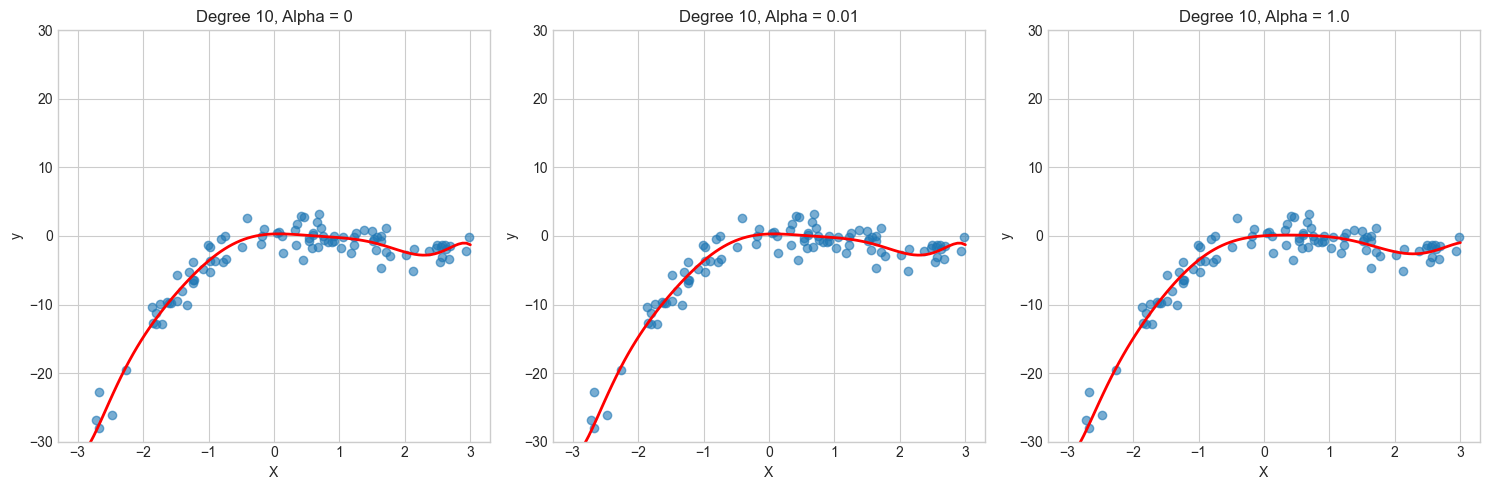

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Polynomial with regularization to prevent overfitting
degree = 10
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
X_plot_poly = poly.transform(X_plot)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

alphas_poly = [0, 0.01, 1.0]

for idx, alpha in enumerate(alphas_poly):
    if alpha == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=alpha)
    
    model.fit(X_poly, y)
    y_pred = model.predict(X_plot_poly)
    
    axes[idx].scatter(X, y, alpha=0.6)
    axes[idx].plot(X_plot, y_pred, 'r-', lw=2)
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(f'Degree {degree}, Alpha = {alpha}')
    axes[idx].set_ylim(-30, 30)

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

## Part 8: Logistic Regression for Classification

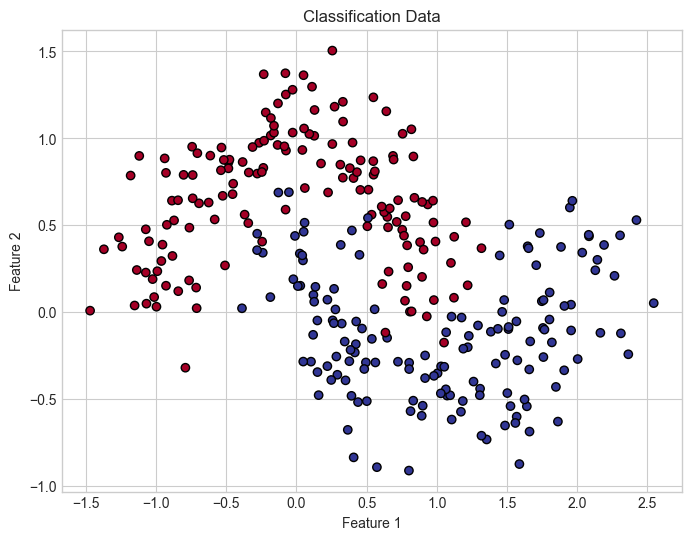

In [14]:
# Generate classification data
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualize data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Data')
plt.show()

**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

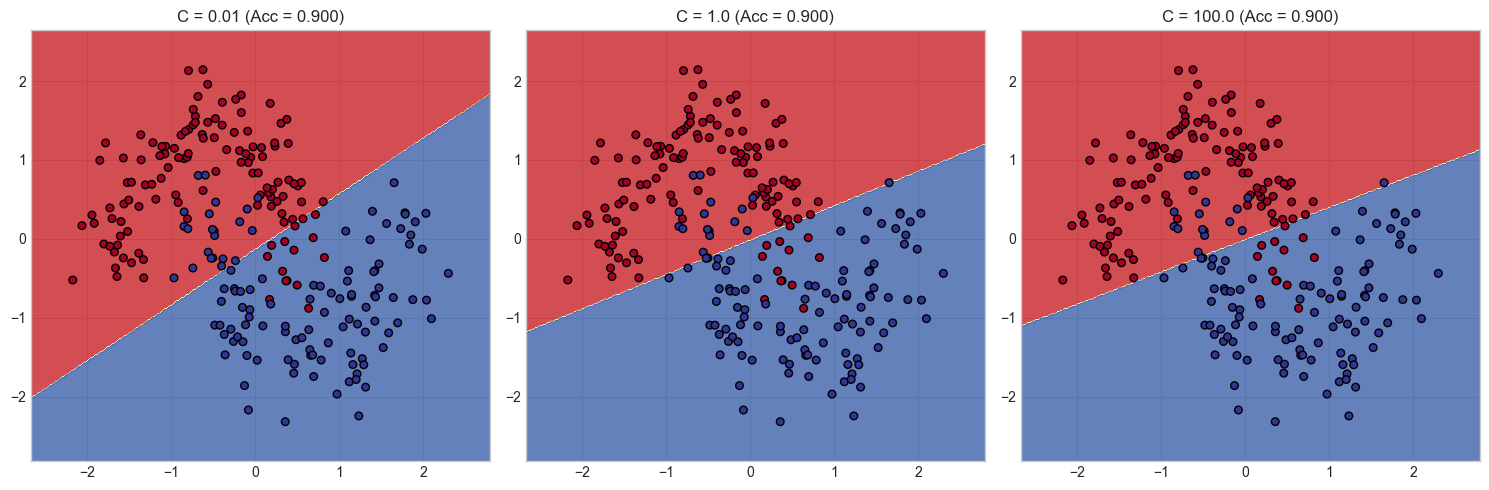

In [15]:
# Decision boundary function
def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
    ax.set_title(title)

# Compare regularization in logistic regression
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

C_values = [0.01, 1.0, 100.0]  # C = 1/alpha (inverse regularization)

for idx, C in enumerate(C_values):
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    acc = model.score(X_test_scaled, y_test)
    plot_decision_boundary(model, X_train_scaled, y_train, axes[idx], 
                          f'C = {C} (Acc = {acc:.3f})')

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

### 🎲 ロジスティック回帰：分類問題への応用名前に「回帰」とありますが、ロジスティック回帰は**分類**アルゴリズムです。#### なぜ線形回帰では分類できないのか？**例：スパムメール判定**線形回帰で試すと：```スコア = 単語頻度1×w1 + 単語頻度2×w2 + ...結果: -5.2, 0.3, 1.8, 25.7, ...問題: これをどうやって「スパム or 正常」に変換する？```出力が連続値（-∞ to +∞）なので、0 or 1 の分類に直接使えません。#### シグモイド関数による変換ロジスティック回帰は、線形回帰の出力を**シグモイド関数**で0〜1の範囲に変換します：```P(y=1) = 1 / (1 + e^(-z))z = wx + b (線形回帰と同じ)```**シグモイド関数の特徴**：```入力(z)    出力P(y=1)-∞    →    0-2    →    0.120     →    0.50+2    →    0.88+∞    →    1.00どんな入力でも、出力は0〜1の範囲に収まるこれを確率として解釈できる！```#### 確率から分類へ```P(スパム) = 0.85 → スパムと判定P(スパム) = 0.23 → 正常メールと判定閾値（デフォルト: 0.5）を超えたら陽性と判定```#### ロジスティック回帰の具体例**顧客の購入予測**：```購入確率 = sigmoid(年齢×w1 + 収入×w2 + 訪問回数×w3 + b)例:年齢30歳、収入500万円、訪問回数10回の顧客z = 30×0.02 + 500×0.001 + 10×0.3 + (-2)  = 0.6 + 0.5 + 3 - 2  = 2.1P(購入) = 1 / (1 + e^(-2.1))        = 1 / (1 + 0.122)        = 0.89 (89%)→ 購入する可能性が高い！```#### 多クラス分類ロジスティック回帰は、2クラスだけでなく多クラスにも対応できます。**ソフトマックス回帰（Softmax Regression）**：```3クラス分類（A, B, C）の例:P(A) = e^(z_A) / (e^(z_A) + e^(z_B) + e^(z_C))P(B) = e^(z_B) / (e^(z_A) + e^(z_B) + e^(z_C))P(C) = e^(z_C) / (e^(z_A) + e^(z_B) + e^(z_C))P(A) + P(B) + P(C) = 1.0 （確率の合計は1）例:P(A) = 0.7P(B) = 0.2P(C) = 0.1→ クラスAと予測```#### 決定境界の可視化ロジスティック回帰の決定境界は直線（または平面）になります：```2次元空間での境界:  特徴量2    ↑    │  ●●●     ○○○    │  ●●●  ／ ○○○    │  ●●● ／  ○○○    │      ／    │  ●●／●    │  ●／●●    └─────────→ 特徴量1境界線の左側: クラス●境界線の右側: クラス○```#### ロジスティック回帰 vs 他の分類器**線形SVM**：- 境界線からの「マージン」を最大化- 外れ値に強い- 確率を直接出力しない**決定木**：- 非線形な境界を作れる- 特徴量間の相互作用を捉える- 解釈しやすい（ルールが見える）**ニューラルネットワーク**：- 複雑な非線形関係を学習- 大量のデータが必要- 計算コストが高い**ロジスティック回帰の強み**：- 計算が速い- 確率を直接出力（意思決定に使いやすい）- 正則化で過学習を防ぎやすい- 大規模データでも使える#### 実務での応用例**1. クレジットカード不正検出**：```P(不正) = sigmoid(金額×w1 + 時刻×w2 + 場所×w3 + ...)P(不正) > 0.9 → 取引を停止P(不正) = 0.5-0.9 → 追加認証を要求P(不正) < 0.5 → 取引を承認```**2. メールの優先度判定**：```P(重要) = sigmoid(送信者×w1 + 件名×w2 + ...)P(重要) > 0.8 → 通知を送るP(重要) < 0.8 → 通知しない```**3. 病気の診断補助**：```P(疾患) = sigmoid(症状1×w1 + 症状2×w2 + ...)P(疾患) > 0.7 → 精密検査を推奨P(疾患) < 0.7 → 経過観察```確率が出力されるので、閾値を調整してリスクとコストのバランスを取れます。

#### 📚 モデルの学習（訓練）

`.fit()`メソッドを呼ぶことで、モデルがデータからパターンを学習します。

**学習プロセスで起こること**：

1. **パラメータの初期化**：
   - モデル内部のパラメータをランダムに設定

2. **パターンの探索**：
   - 訓練データを繰り返し分析
   - 特徴量とラベルの関係を探す

3. **最適化**：
   - 予測誤差を最小化するようにパラメータを調整
   - 勾配降下法などの最適化アルゴリズムを使用

4. **収束判定**：
   - 誤差が十分小さくなったら終了
   - または、最大イテレーション数に達したら終了

**学習時間**：
- データ量、特徴量数、モデルの複雑さに依存
- 数秒〜数時間まで様々

学習が完了すると、モデルは新しいデータに対して予測できるようになります。

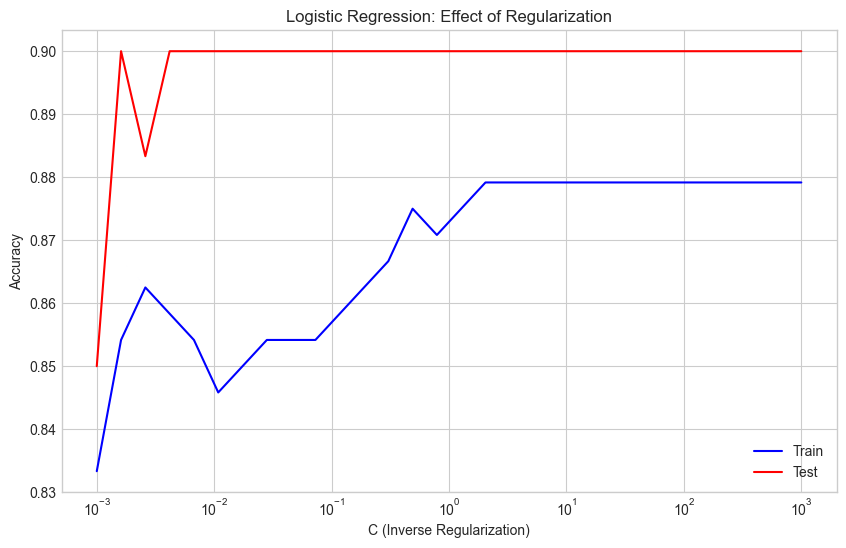

Optimal C: 0.0016


In [16]:
# ============================================================
# [コードの説明]
# ============================================================

# C parameter sweep
C_range = np.logspace(-3, 3, 30)

train_scores = []
test_scores = []

for C in C_range:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    train_scores.append(model.score(X_train_scaled, y_train))
    test_scores.append(model.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.semilogx(C_range, train_scores, 'b-', label='Train')
plt.semilogx(C_range, test_scores, 'r-', label='Test')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Effect of Regularization')
plt.legend()
plt.grid(True)
plt.show()

optimal_C = C_range[np.argmax(test_scores)]
print(f"Optimal C: {optimal_C:.4f}")

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

### 📈 線形回帰：連続値を予測する線形回帰は、機械学習の中で最も基本的で重要なアルゴリズムです。#### 線形回帰の仕組み**目的**: データに最もよくフィットする直線（または平面）を見つける**1次元の場合**：```y = wx + by: 予測値（目的変数）x: 入力値（説明変数）w: 重み（傾き）b: バイアス（切片）```**例：広告費と売上の関係**```売上 = 広告費 × 5.2 + 100広告費が1万円増えると、売上が5.2万円増える広告費ゼロでも、基本売上が100万円ある```#### 最小二乗法（Ordinary Least Squares）線形回帰は、実際の値と予測値の差（残差）の二乗和を最小にする直線を見つけます。```最小化: Σ(実際の値 - 予測値)²```**イメージ**：```データ点: ●  ●    ●  ●          ●    ●  ●    ●直線:     ─────────────────          ↕    ↕  ↕    ↕        残差（誤差）すべての残差の二乗の和が最小になる直線を探す```#### 多次元の線形回帰実世界の問題では、複数の特徴量を使います：**住宅価格予測の例**：```価格 = 面積×w1 + 築年数×w2 + 駅距離×w3 + 階数×w4 + b例:価格 = 面積×50 + 築年数×(-30) + 駅距離×(-10) + 階数×20 + 100070㎡、築5年、駅5分、3階の物件:価格 = 70×50 + 5×(-30) + 5×(-10) + 3×20 + 1000     = 3500 - 150 - 50 + 60 + 1000     = 4360万円```**重みの解釈**：- w1 = 50: 面積が1㎡増えると、価格が50万円上がる- w2 = -30: 築年数が1年増えると、価格が30万円下がる- w3 = -10: 駅から1分遠いと、価格が10万円下がる- w4 = 20: 階数が1階上がると、価格が20万円上がる#### 線形回帰の仮定線形回帰は、以下を仮定しています：**1. 線形性**：入力と出力が線形関係にある**2. 独立性**：各サンプルが独立している**3. 正規性**：誤差が正規分布に従う**4. 等分散性**：誤差の分散が一定**5. 多重共線性がない**：特徴量同士が強く相関していないこれらの仮定が満たされない場合、モデルの性能が低下します。#### 線形回帰の利点と欠点**利点**：- 計算が速い（大規模データでも使える）- 解釈しやすい（重みを見れば分かる）- 実装が簡単- 外挿（範囲外の予測）もある程度可能**欠点**：- 非線形関係を捉えられない- 外れ値の影響を受けやすい- 特徴量の前処理（スケーリングなど）が重要- 特徴量間の相互作用を自動で考慮しない#### 実務での使い方**1. まずは試す**：どんな問題でも、まず線形回帰を試すのが定石**2. ベースラインとして使う**：複雑なモデルと比較する基準になる**3. 特徴量エンジニアリング**：多項式特徴量や交互作用項を追加して非線形関係を捉える```python# 2次の項を追加X_poly = [x, x²]# 交互作用項を追加X_interaction = [x1, x2, x1×x2]```**4. 正則化を使う**：過学習を防ぐため、Ridge や Lasso を使う

### 🎲 ロジスティック回帰：分類問題への応用名前に「回帰」とありますが、ロジスティック回帰は**分類**アルゴリズムです。#### なぜ線形回帰では分類できないのか？**例：スパムメール判定**線形回帰で試すと：```スコア = 単語頻度1×w1 + 単語頻度2×w2 + ...結果: -5.2, 0.3, 1.8, 25.7, ...問題: これをどうやって「スパム or 正常」に変換する？```出力が連続値（-∞ to +∞）なので、0 or 1 の分類に直接使えません。#### シグモイド関数による変換ロジスティック回帰は、線形回帰の出力を**シグモイド関数**で0〜1の範囲に変換します：```P(y=1) = 1 / (1 + e^(-z))z = wx + b (線形回帰と同じ)```**シグモイド関数の特徴**：```入力(z)    出力P(y=1)-∞    →    0-2    →    0.120     →    0.50+2    →    0.88+∞    →    1.00どんな入力でも、出力は0〜1の範囲に収まるこれを確率として解釈できる！```#### 確率から分類へ```P(スパム) = 0.85 → スパムと判定P(スパム) = 0.23 → 正常メールと判定閾値（デフォルト: 0.5）を超えたら陽性と判定```#### ロジスティック回帰の具体例**顧客の購入予測**：```購入確率 = sigmoid(年齢×w1 + 収入×w2 + 訪問回数×w3 + b)例:年齢30歳、収入500万円、訪問回数10回の顧客z = 30×0.02 + 500×0.001 + 10×0.3 + (-2)  = 0.6 + 0.5 + 3 - 2  = 2.1P(購入) = 1 / (1 + e^(-2.1))        = 1 / (1 + 0.122)        = 0.89 (89%)→ 購入する可能性が高い！```#### 多クラス分類ロジスティック回帰は、2クラスだけでなく多クラスにも対応できます。**ソフトマックス回帰（Softmax Regression）**：```3クラス分類（A, B, C）の例:P(A) = e^(z_A) / (e^(z_A) + e^(z_B) + e^(z_C))P(B) = e^(z_B) / (e^(z_A) + e^(z_B) + e^(z_C))P(C) = e^(z_C) / (e^(z_A) + e^(z_B) + e^(z_C))P(A) + P(B) + P(C) = 1.0 （確率の合計は1）例:P(A) = 0.7P(B) = 0.2P(C) = 0.1→ クラスAと予測```#### 決定境界の可視化ロジスティック回帰の決定境界は直線（または平面）になります：```2次元空間での境界:  特徴量2    ↑    │  ●●●     ○○○    │  ●●●  ／ ○○○    │  ●●● ／  ○○○    │      ／    │  ●●／●    │  ●／●●    └─────────→ 特徴量1境界線の左側: クラス●境界線の右側: クラス○```#### ロジスティック回帰 vs 他の分類器**線形SVM**：- 境界線からの「マージン」を最大化- 外れ値に強い- 確率を直接出力しない**決定木**：- 非線形な境界を作れる- 特徴量間の相互作用を捉える- 解釈しやすい（ルールが見える）**ニューラルネットワーク**：- 複雑な非線形関係を学習- 大量のデータが必要- 計算コストが高い**ロジスティック回帰の強み**：- 計算が速い- 確率を直接出力（意思決定に使いやすい）- 正則化で過学習を防ぎやすい- 大規模データでも使える#### 実務での応用例**1. クレジットカード不正検出**：```P(不正) = sigmoid(金額×w1 + 時刻×w2 + 場所×w3 + ...)P(不正) > 0.9 → 取引を停止P(不正) = 0.5-0.9 → 追加認証を要求P(不正) < 0.5 → 取引を承認```**2. メールの優先度判定**：```P(重要) = sigmoid(送信者×w1 + 件名×w2 + ...)P(重要) > 0.8 → 通知を送るP(重要) < 0.8 → 通知しない```**3. 病気の診断補助**：```P(疾患) = sigmoid(症状1×w1 + 症状2×w2 + ...)P(疾患) > 0.7 → 精密検査を推奨P(疾患) < 0.7 → 経過観察```確率が出力されるので、閾値を調整してリスクとコストのバランスを取れます。

## Summary

In this notebook, you learned:

### Linear Regression
- Basic linear regression fitting
- Effect of noise on model performance

### Regularization
- **Ridge**: L2 penalty, shrinks coefficients
- **Lasso**: L1 penalty, feature selection (sparse)
- **ElasticNet**: Combination of L1 and L2

### Parameter Effects
- Higher alpha = more regularization = simpler model
- Regularization helps with multicollinearity
- Polynomial features + regularization prevents overfitting

### Key Takeaways
- Use Ridge when all features might be relevant
- Use Lasso for automatic feature selection
- Regularization is crucial for high-dimensional data
- Always tune the regularization parameter (alpha/C)

### Next Steps
Continue to **Notebook 05** for tree and ensemble models.

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
